# using gradient boosted decision trees as a meta-classifier

In [31]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "pROC"         "tidyr"        "dplyr"        "glmnet"       "foreach"     
 [6] "Matrix"       "xgboost"      "ggplot2"      "RColorBrewer" "stats"       
[11] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[16] "base"

In [32]:
split_data <- function(outcomes,p=0.75) {
    n <- length(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

## classify iris data using three different base learners

In [33]:
data(iris)

In [34]:
df_nosetosa <- iris[iris$Species != "setosa",]
df_nosetosa$Species <- factor(df_nosetosa$Species)
rownames(df_nosetosa) <- NULL
X <- df_nosetosa[,-c(5)]
y <- as.numeric(df_nosetosa[,c(5)]) - 1

traintest_inds <- split_data(y,p=0.75)
X_traintest <- X[c(traintest_inds),]
y_traintest <- y[traintest_inds]
X_holdout <- X[-traintest_inds,]
y_holdout <- y[-traintest_inds]

df_nosetosa_train <- df_nosetosa[traintest_inds,]
df_nosetosa_test <- df_nosetosa[-traintest_inds,]

In [35]:
glm_sl <- glm(Species ~ Sepal.Length, data=df_nosetosa_train, family=binomial)
glm_sw <- glm(Species ~ Sepal.Width, data=df_nosetosa_train, family=binomial)
glm_pl <- glm(Species ~ Petal.Length, data=df_nosetosa_train, family=binomial)

### training accuracy for each base learner

In [36]:
mean(round(glm_sl$fitted.values) == y_traintest)
mean(round(glm_sw$fitted.values) == y_traintest)
mean(round(glm_pl$fitted.values) == y_traintest)

[1] 0.72

[1] 0.5466667

[1] 0.92

### construct meta-features using the predictions of the three base learners

In [37]:
df_meta <- data.frame("sl.score"=glm_sl$fitted.values,
                      "sw.score"=glm_sw$fitted.values,
                      "pl.score"=glm_pl$fitted.values)

### majority vote isn't that great when some of the voters are significantly worse than others

In [38]:
mean(round(rowMeans(round(df_meta),1)) == y_traintest)

[1] 0.7733333

## instead, learn a decision tree in a meta-feature space
meta features are the scores from the base learners

In [39]:
param <- list("objective" = "binary:logistic",
              "max.depth" = 2,
              "eta" = 0.25
              )

gbdt <- xgboost(
    params = param,
    data = as.matrix(df_meta),
    label = as.numeric(y_traintest),
    nround = 10,
    verbose = FALSE,
    missing=NA
)

### training accuracy of the meta-classifier 

In [40]:
preds_overfit <- predict(gbdt,as.matrix(df_meta), missing=NA)
mean(round(preds_overfit) == y_traintest)

[1] 0.9333333

### test accuracies of the base learners

In [18]:
preds_holdout_sl <- predict.glm(object = glm_sl, newdata = df_nosetosa_test, type = "response")
preds_holdout_sw <- predict.glm(object = glm_sw, newdata = df_nosetosa_test, type = "response")
preds_holdout_pl <- predict.glm(object = glm_pl, newdata = df_nosetosa_test, type = "response")

mean(round(preds_holdout_sl) == y_holdout)
mean(round(preds_holdout_sw) == y_holdout)
mean(round(preds_holdout_pl) == y_holdout)

df_meta_test <- data.frame("sl.score"=preds_holdout_sl,
                           "sw.score"=preds_holdout_sw,
                           "pl.score"=preds_holdout_pl)

[1] 0.6

[1] 0.48

[1] 0.88

### test accuracy of the meta-classifier

In [19]:
preds_holdout <- predict(gbdt,as.matrix(df_meta_test), missing=NA)
mean(round(preds_holdout) == y_holdout)

[1] 0.88

# ROC curves

In [25]:
data(aSAH)

In [27]:
rocs100 <- roc(aSAH$outcome, aSAH$s100, percent = TRUE, partial.auc=c(100, 90))
rocwfns <- roc(aSAH$outcome, aSAH$wfns, percent = TRUE, partial.auc=c(100, 90))

In [28]:
cis100 <- ci(rocs100, of = "se", sp = seq(0, 100, 5), boot.n=10000)
ciwfns <- ci(rocwfns, of = "threshold", threshold=4.5, boot.n=10000)

In [29]:
rtest <- roc.test(rocs100, rocwfns, boot.n=10000)


Call:
roc.default(response = aSAH$outcome, predictor = aSAH$s100, percent = TRUE,     partial.auc = c(100, 90))

Data: aSAH$s100 in 72 controls (aSAH$outcome Good) < 41 cases (aSAH$outcome Poor).
Partial area under the curve (specificity 100%-90%): 3.276%


Call:
roc.default(response = aSAH$outcome, predictor = aSAH$wfns, percent = TRUE,     partial.auc = c(100, 90))

Data: aSAH$wfns in 72 controls (aSAH$outcome Good) < 41 cases (aSAH$outcome Poor).
Partial area under the curve (specificity 100%-90%): 3.344%

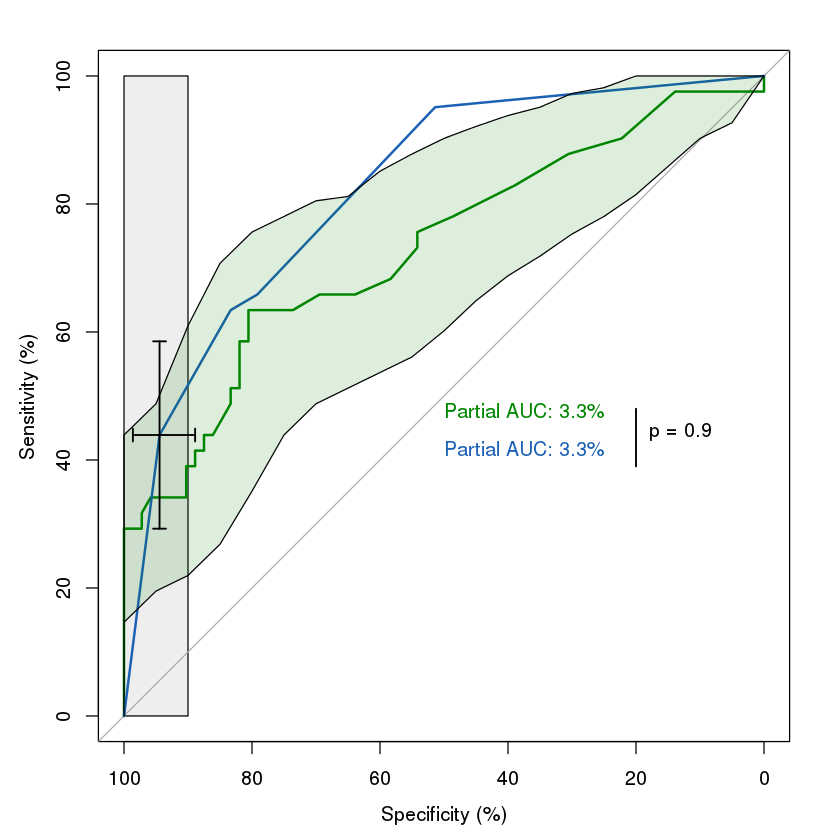

In [30]:
# png("demo.png")
plot(rocs100, col="#008600", max.auc.polygon=TRUE, print.auc=TRUE, print.auc.y=48)
plot(rocwfns, col="#1c61b6", add=TRUE, print.auc=TRUE, print.auc.y=42)
plot(cis100, type="shape", col="#00860022", no.roc=TRUE)
plot(ciwfns, type="bars", lwd=1.5)
text(18, 45, sprintf("p = %.1f", rtest$p.value), adj=c(0,1))
lines(c(20, 20), c(39, 48), lwd=1.5)
# dev.off()

In [54]:
roc_iris <- roc(y_holdout, preds_holdout)
ci_iris <- ci(roc_iris, of = "se", sp = seq(0, 1, 0.01))


Call:
roc.default(response = y_holdout, predictor = preds_holdout)

Data: preds_holdout in 13 controls (y_holdout 0) < 12 cases (y_holdout 1).
Area under the curve: 0.9071

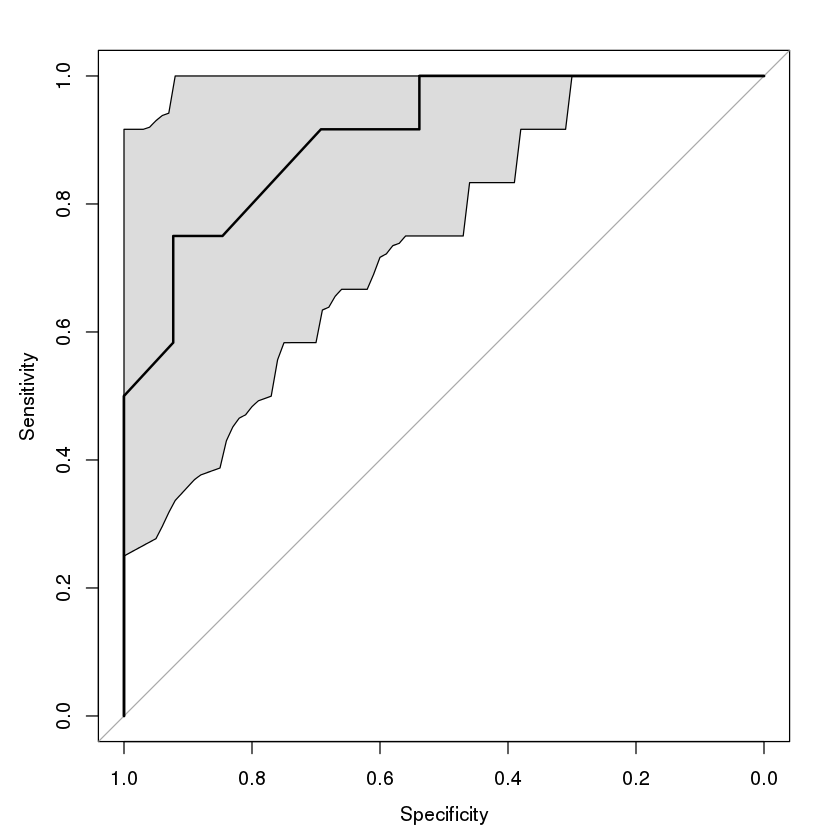

In [55]:
plot(roc_iris)
plot(ci_iris, type="shape")

In [132]:
mattcc <- function(true_classes, predicted_classes) {
        
    pos <- true_classes == 1
    neg <- true_classes == 0
    
    TP <- sum( predicted_classes[pos] == true_classes[pos] )
    TN <- sum( predicted_classes[neg] == true_classes[neg] )
    FP <- sum( predicted_classes[pos] != true_classes[pos] )
    FN <- sum( predicted_classes[neg] != true_classes[neg] )  
    
    N1 <- TP*TN
    N2 <- FP*FN
    D1 <- TP+FP
    D2 <- TP+FN
    D3 <- TN+FP
    D4 <- TN+FN
    
    N <- N1-N2
    D <- D1*D2*D3*D4
    
    if (D==0) {
        m <- 0
    } else {
        M <- N/sqrt(D)
    }
    
    return(M)
}

In [133]:
mattcc(y_holdout, round(preds_holdout))

[1] 0.6000125

In [134]:
mattcc(y_traintest,round(preds_overfit))

[1] 0.8692937